In [1]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from torch.utils.data import Dataset

from pysmilesutils.augment import MolRandomizer, SMILESRandomizer
from pysmilesutils.tokenize import SMILESAtomTokenizer

In [2]:
DATA_PATH = Path("../../data/pande_dataset.pickle")

In [3]:
df = pd.read_pickle(DATA_PATH)
print(df.columns)

Index(['reactants', 'reaction_class', 'products', 'set', 'reactant_ROMol',
       'products_ROMol'],
      dtype='object')


In [4]:
print(set(list(df["set"])))

{'test', 'valid', 'train'}


In [5]:
idxs = [4, 274, 856]
example_mols = [df["reactant_ROMol"][idx] for idx in idxs]
example_smiles = [Chem.MolToSmiles(mol) for mol in example_mols]

Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1


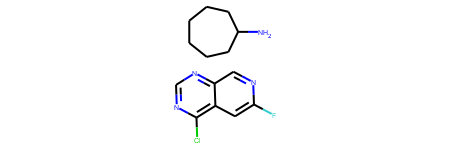

In [6]:
print(example_smiles[0])
example_mols[0]

CCOC(=O)c1cn2c3c(cc(I)cc3c1=O)OCC2


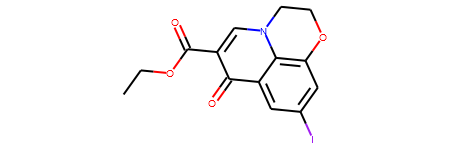

In [7]:
print(example_smiles[1])
example_mols[1]

CC(C)(C)OC(=O)NCC(N)=S.CCOC(=O)C(=O)CBr


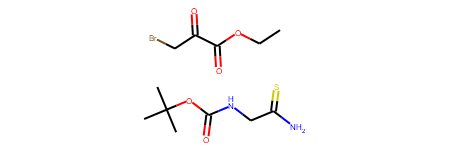

In [8]:
print(example_smiles[2])
example_mols[2]

In [9]:
example_products = [df["products_ROMol"][idx] for idx in idxs]
example_smiles_prod = [Chem.MolToSmiles(mol) for mol in example_products]

Fc1cc2c(NC3CCCCCC3)ncnc2cn1


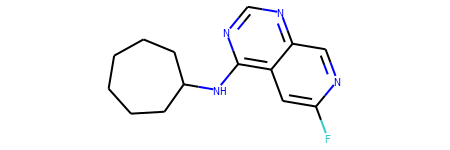

In [10]:
print(example_smiles_prod[0])
example_products[0]

O=C(O)c1cn2c3c(cc(I)cc3c1=O)OCC2


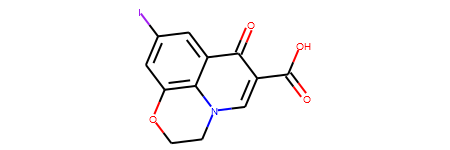

In [11]:
print(example_smiles_prod[1])
example_products[1]

CCOC(=O)c1csc(CNC(=O)OC(C)(C)C)n1


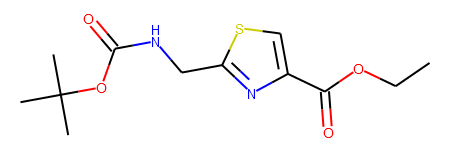

In [12]:
print(example_smiles_prod[2])
example_products[2]

In [13]:
aug = SMILESRandomizer()

In [14]:
aug_smiles = [aug(smi)[0] for smi in example_smiles]

In [15]:
print(f"{'Original':<50}{'Augmented'}")
for idx, smi in enumerate(example_smiles):
    aug_smi = aug_smiles[idx]
    print(f"{smi:<50}{aug_smi}")

Original                                          Augmented
Fc1cc2c(Cl)ncnc2cn1.NC1CCCCCC1                    C1CCCCCC1N.n1cnc2cnc(F)cc2c1Cl
CCOC(=O)c1cn2c3c(cc(I)cc3c1=O)OCC2                c1(C(=O)OCC)c(=O)c2c3n(c1)CCOc3cc(I)c2
CC(C)(C)OC(=O)NCC(N)=S.CCOC(=O)C(=O)CBr           CC(C)(OC(=O)NCC(N)=S)C.C(=O)(CBr)C(OCC)=O


In [16]:
aug = MolRandomizer()

In [17]:
aug_mols = [aug(mol) for mol in example_mols]

In [18]:
class WrapperDataset(Dataset):
    def __init__(self, mols):
        super(WrapperDataset, self).__init__()
        self.mols = mols

    def __len__(self):
        return len(self.mols)

    def __getitem__(self, item):
        mol = self.mols[item]
        return mol

In [19]:
def load_data(data_path):
    df = pd.read_pickle(data_path)
    mols = list(df["reactant_ROMol"]) + list(df["products_ROMol"])
    dataset = WrapperDataset(mols)
    return dataset

In [20]:
dataset = load_data(DATA_PATH)

In [21]:
tokeniser = SMILESAtomTokenizer()

In [22]:
example_idxs = [45, 78, 23, 98]
example_mols = [dataset[idx] for idx in example_idxs]
example_smiles = [Chem.MolToSmiles(mol) for mol in example_mols]

In [23]:
tokens = tokeniser.tokenize(example_smiles)
for mol_tokens in tokens:
    print(mol_tokens)

['^', 'C', 'C', '(', '=', 'O', ')', 'N', '1', '[', 'C', '@', 'H', ']', '(', 'C', '(', '=', 'O', ')', '[', 'O', '-', ']', ')', 'C', 'C', '(', '=', 'O', ')', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', 'N', '(', 'C', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', ')', 'C', '(', '=', 'O', ')', '[', 'C', '@', 'H', ']', '1', 'C', 'C', '1', '2', 'C', 'C', '3', 'C', 'C', '(', 'C', 'C', '(', 'C', '3', ')', 'C', '1', ')', 'C', '2', '.', 'N', 'C', 'C', '(', '=', 'O', ')', 'O', 'C', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', '&']
['^', 'C', 'C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', '(', 'O', ')', 'c', '2', 'n', 'c', 'c', '(', 'C', 'c', '3', 'c', 'c', 'c', 'c', 'c', '3', ')', 'c', 'c', '2', 'n', '(', 'C', 'c', '2', 'c', 'c', 'c', '(', 'S', '(', 'C', ')', '(', '=', 'O', ')', '=', 'O', ')', 'c', 'c', '2', ')', 'c', '1', '=', 'O', '.', 'N', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1', '&']
['^', 'C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '(', 'Br', ')', 'c', 'c', '1', '.', 'N', 'c', '1', '

In [24]:
tokeniser.add_tokens([">>"])

In [25]:
reaction = Chem.MolToSmiles(example_mols[0]) + ">>" + Chem.MolToSmiles(example_products[0])
print(reaction)

CC(=O)N1[C@H](C(=O)[O-])CC(=O)c2ccccc2N(Cc2ccccc2)C(=O)[C@H]1CC12CC3CC(CC(C3)C1)C2.NCC(=O)OCc1ccccc1>>Fc1cc2c(NC3CCCCCC3)ncnc2cn1


In [26]:
tokens = tokeniser.tokenize([reaction])
for tokens_ in tokens:
    print(tokens_)

['^', 'C', 'C', '(', '=', 'O', ')', 'N', '1', '[', 'C', '@', 'H', ']', '(', 'C', '(', '=', 'O', ')', '[', 'O', '-', ']', ')', 'C', 'C', '(', '=', 'O', ')', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', 'N', '(', 'C', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', ')', 'C', '(', '=', 'O', ')', '[', 'C', '@', 'H', ']', '1', 'C', 'C', '1', '2', 'C', 'C', '3', 'C', 'C', '(', 'C', 'C', '(', 'C', '3', ')', 'C', '1', ')', 'C', '2', '.', 'N', 'C', 'C', '(', '=', 'O', ')', 'O', 'C', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', '>>', 'F', 'c', '1', 'c', 'c', '2', 'c', '(', 'N', 'C', '3', 'C', 'C', 'C', 'C', 'C', 'C', '3', ')', 'n', 'c', 'n', 'c', '2', 'c', 'n', '1', '&']


In [27]:
tokeniser1 = SMILESAtomTokenizer(smiles=example_smiles)
print(tokeniser1.vocabulary)
print(tokeniser.vocabulary)

{' ': 0, '^': 1, '&': 2, 'C': 3, '(': 4, '=': 5, 'O': 6, ')': 7, 'N': 8, '1': 9, '[': 10, '@': 11, 'H': 12, ']': 13, '-': 14, 'c': 15, '2': 16, '3': 17, '.': 18, 'n': 19, 'S': 20, 'Br': 21, 'F': 22}
{' ': 0, '^': 1, '&': 2}


In [28]:
tokeniser1.add_tokens([">>", "<MASK>"])
print(tokeniser1.vocabulary)

{' ': 0, '^': 1, '&': 2, 'C': 3, '(': 4, '=': 5, 'O': 6, ')': 7, 'N': 8, '1': 9, '[': 10, '@': 11, 'H': 12, ']': 13, '-': 14, 'c': 15, '2': 16, '3': 17, '.': 18, 'n': 19, 'S': 20, 'Br': 21, 'F': 22}


In [29]:
react_enc = tokeniser(reaction)
react_enc1 = tokeniser1(reaction)
print(react_enc)
print(react_enc1)

[tensor([ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1,  2])]
[tensor([ 1,  3,  3,  4,  5,  6,  7,  8,  9, 10,  3, 11, 12, 13,  4,  3,  4,  5,
         6,  7, 10,  6, 14, 13,  7,  3,  3,  4,  5,  6,  7, 15, 16, 15, 15, 15,
        15, 15, 16,  8,  4,  3, 15, 16, 15, 15, 15, 15, 15, 16,  7,  3,  4,  5,
         6,  7, 10,  3, 11, 12, 13,  9,  3,  3,  9, 16,  3,  3, 17,  3,  3,  4,
         3,  3,  4,  3, 17,  7,  3,  9,  7,  3, 16, 18,  8,  3,  3,  4,  5,  6,
         7, 

In [30]:
rev_smiles = tokeniser.tokenize(example_smiles)
[smi.reverse() for smi in rev_smiles]
rev_smiles = tokeniser.detokenize(rev_smiles)
print(rev_smiles)

['1ccccc1cCO)O=(CCN.2C)1C)3C(CC(CC3CC21CC1]H@C[)O=(C)2ccccc2cC(N2ccccc2c)O=(CC)]-O[)O=(C(]H@C[1N)O=(CC', '1CCCC1NCCN.O=1c)2cc)O=)O=()C(S(ccc2cC(n2cc)3ccccc3cC(ccn2c)O(c1c)O=(COCC', '1ccccc1cN.1cc)Br(ccc1c)O=(COC', 'C1ccc)F2ccc)F)F()F(C(cc2cN)O=(C(cc1c)O=(COC']


In [31]:
rev_mols = [Chem.MolFromSmiles(smi) for smi in rev_smiles]

CC(=O)N1[C@H](C(=O)[O-])CC(=O)c2ccccc2N(Cc2ccccc2)C(=O)[C@H]1CC12CC3CC(CC(C3)C1)C2.NCC(=O)OCc1ccccc1


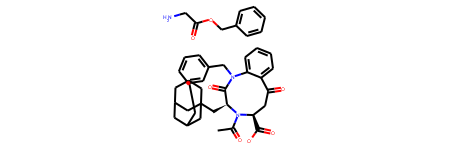

In [32]:
print(example_smiles[0])
example_mols[0]

In [33]:
print(rev_smiles[0])
rev_mols[0]

1ccccc1cCO)O=(CCN.2C)1C)3C(CC(CC3CC21CC1]H@C[)O=(C)2ccccc2cC(N2ccccc2c)O=(CC)]-O[)O=(C(]H@C[1N)O=(CC


CCOC(=O)c1c(O)c2ncc(Cc3ccccc3)cc2n(Cc2ccc(S(C)(=O)=O)cc2)c1=O.NCCN1CCCC1


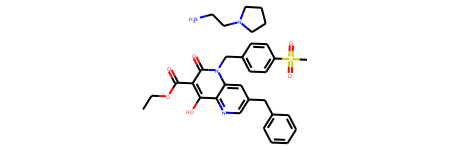

In [34]:
print(example_smiles[1])
example_mols[1]

In [35]:
print(rev_smiles[1])
rev_mols[1]

1CCCC1NCCN.O=1c)2cc)O=)O=()C(S(ccc2cC(n2cc)3ccccc3cC(ccn2c)O(c1c)O=(COCC


In [36]:
print(rev_smiles[2])
rev_mols[2]

1ccccc1cN.1cc)Br(ccc1c)O=(COC


In [38]:
reactant_mols = df["reactant_ROMol"]
product_mols = df["products_ROMol"]
reactant_smiles = [Chem.MolToSmiles(mol) for mol in reactant_mols]
product_smiles = [Chem.MolToSmiles(mol) for mol in product_mols]

In [39]:
# Analyse number of characters in each
react_num_chars = [len(smi) for smi in reactant_smiles]
prod_num_chars = [len(smi) for smi in product_smiles]

In [40]:
print(f"Max number of reactant chars: {max(react_num_chars)}")
print(f"Max number of product chars: {max(prod_num_chars)}")

Max number of reactant chars: 197
Max number of product chars: 196
